In [1]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

#spectra imports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets

### Set up model training

In [2]:
obs_key = 'cell_type_annotations'

In [3]:
# adata = spc.sample_data.load()
# adata

adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [4]:
adata.X = adata.layers['imputed_count']

In [5]:
adata.obs['cell_type'].value_counts()

cell_type
B-cell            10417
Th2                2150
Cd8 T-cell         1517
Treg                516
Resting T-cell      492
Tfh                 472
NK                  272
Name: count, dtype: int64

In [8]:
def capitalize_strings(d):
    if isinstance(d, dict):
        return {k: capitalize_strings(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [s.capitalize() if isinstance(s, str) else s for s in d]
    elif isinstance(d, str):
        return d.capitalize()
    else:
        return d

# annotations = capitalize_strings(annotations)
# annotations

In [7]:
adata_b = adata[adata.obs['cell_type'] == 'B-cell']
sc.tl.pca(adata_b)

adata_b

/ix/djishnu/alw399/envs/spectra/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


AnnData object with n_obs × n_vars = 10417 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    uns: 'pca'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [11]:
sc.pp.neighbors(adata_b, n_neighbors=15, use_rep='X_pca')

/tmp/ipykernel_240873/3689706997.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_b, resolution=0.2)


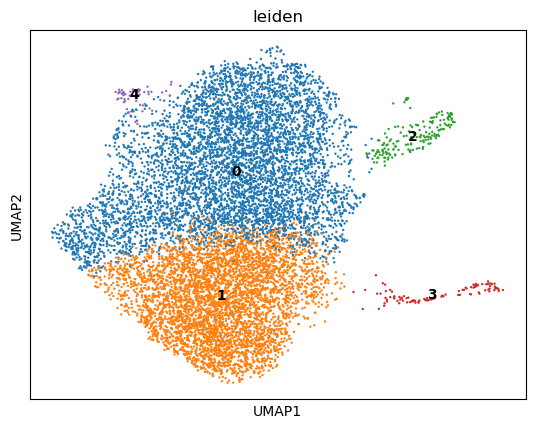

In [12]:
sc.tl.leiden(adata_b, resolution=0.2)
sc.tl.umap(adata_b)
sc.pl.umap(adata_b, color=['leiden'], legend_loc='on data')

In [13]:
adata_orig = sc.read_h5ad('../../data/slideseq/day3_1.h5ad')
adata_orig = adata_orig[adata_b.obs.index, :]
adata_orig.obs['leiden'] = adata_b.obs['leiden']
adata_orig

/tmp/ipykernel_240873/1384738885.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_orig.obs['leiden'] = adata_b.obs['leiden']


AnnData object with n_obs × n_vars = 10417 × 24649
    obs: 'cluster', 'rctd_cluster', 'leiden'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [14]:
marker_dict = {
    'GC': ['Bcl6', 'Fas', 'Cd40'], 
    'memory': ['Cd27', 'Cd69', 'Cd95', 'Bcl2', 'Il2rb'],
    'naive': ['Cd20', 'Cd38'], # Cd27-, Cd38low
}

mapping = {
    0: 'B_memory',
    1: 'B_GC',
    2: 'B_memory',
    3: 'B_memory',
    4: 'B_naive',
}

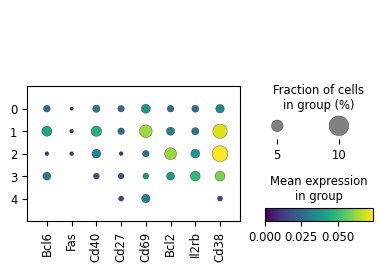

In [15]:
marker_genes = [gene for genes in marker_dict.values() for gene in genes if gene in adata_orig.var_names]
sc.pl.dotplot(adata_orig, var_names=marker_genes, groupby='leiden', cmap='viridis')

In [16]:
adata_b.obs['leiden'] = adata_b.obs['leiden'].astype(int)
adata_b.obs['cell_type'] = [mapping[leiden] for leiden in adata_b.obs['leiden']]
adata_b

AnnData object with n_obs × n_vars = 10417 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int', 'leiden'
    var: 'n_counts'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [25]:
adata.obs['cell_type_annotations'] = adata.obs['cell_type'].astype(str).copy()
adata.obs.loc[adata_b.obs.index, 'cell_type_annotations'] = adata_b.obs['cell_type'].astype(str)
adata.obs['cell_type_annotations'].value_counts()

cell_type_annotations
B_memory          5914
B_GC              4441
Th2               2150
Cd8 T-cell        1517
Treg               516
Resting T-cell     492
Tfh                472
NK                 272
B_naive             62
Name: count, dtype: int64

In [26]:
mapping = {
    'Cd8 T-cell': 'CD8_T',
    # 'Th2': 'CD4_T',
    # 'Tfh': 'CD4_T',
}

adata.obs['cell_type_annotations'] = adata.obs['cell_type_annotations'].map(lambda x: mapping.get(x, x))
adata.obs['cell_type_annotations'].value_counts()

cell_type_annotations
B_memory          5914
B_GC              4441
Th2               2150
CD8_T             1517
Treg               516
Resting T-cell     492
Tfh                472
NK                 272
B_naive             62
Name: count, dtype: int64

In [ ]:
# annotations = spc.default_gene_sets.load()

annotations = {
    'Th2': {
        'Th2_SLIDE_Day3': [
            'Il2ra', 'Glycam1', 'Lrg1', 'Plvap', 'Enpp2', 'Egfl7', 'Ecscr', 'Csf2rb',
            'Serpinh1', 'Col4a1', 'Hspg2', 'Cd63', 'Pdia3', 'Marcksl1', 'Actn1'
        ],
        'Th2_SLIDE_Day5': [
            'Ccr7', 'Ccl5', 'Ccl21a'
        ]
    },
    'Tfh': {
        'Tfh_SLIDE_Day3': [
            'Bcl6', 'Cxcr5', 'Cd22', 'Ighm', 'Ighd', 'Cd79a', 'Cd79b'
        ],
        'Tfh_SLIDE_Day5': [
            'Bcl6', 'Cxcr5', 'Cd79b', 'Pou2af1', 'Cd79a', 'Ms4a1'
        ]
    },
    'global': {
        "REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM": 
            ["Abce1","Abl2","Adar","Ager","Akt1","Akt2","Akt3","Alpk1","App","Arih1","Atf1","Atf2","Becn1","Birc2","Birc3","Brwd1","Camk2a","Camk2b","Camk2d","Camk2g","Canx","Casp1","Casp3","Casp8","Cbl","Cd27","Cd4","Cd40","Cd40lg","Cd70","Cdk1","Cdkn1b","Cenps","Cenpx","Chuk","Clcf1","Cntf","Cntfr","Creb1","Crk","Crkl","Crlf1","Csf1","Csf1r","Csf2","Csf2rb","Csf2rb2","Csf3","Csk","Ctf1","Ctsg","Cul1","Dhx9","Dnajc3","Dus2","Dusp3","Dusp4","Dusp6","Dusp7","Ebi3","Eda","Eda2r","Edar","Edaradd","Eif2ak2","Eif4a1","Eif4a2","Eif4a3","Eif4e","Eif4e2","Eif4e3","Eif4g1","Eif4g2","Eif4g3","Elob","Eloc","Faap100","Faap20","Faap24","Fanca","Fancb","Fancc","Fance","Fancf","Fancg","Fancl","Fancm","Fbxw11","Flnb","Flt3l","Fos","Foxo3","Fyn","Gh","Ghr","Grap2","Grb10","Grb2","Gsdmd","H3c1","H3c10","H3c11","H3c13","H3c14","H3c15","H3c2","H3c3","H3c4","H3c6","H3c7","H3c8","Hck","Hmgb1","Hras","Hsp90b1","Hspa1a","Hspa1b","Hspa1l","Hspa2","Hspa8","Ifit1bl2","Ifna1","Ifna11","Ifna12","Ifna13","Ifna14","Ifna15","Ifna16","Ifna2","Ifna4","Ifna5","Ifna6","Ifna7","Ifna9","Ifnab","Ifnar1","Ifnar2","Ifnb1","Ifng","Ifngr1","Ifngr2","Ifnl2","Ifnl3","Ifnlr1","Ikbkb","Ikbkg","Il10","Il10ra","Il10rb","Il11","Il11ra1","Il12a","Il12b","Il12rb1","Il12rb2","Il13","Il13ra1","Il13ra2","Il15","Il15ra","Il16","Il18","Il18bp","Il18r1","Il18rap","Il19","Il1a","Il1b","Il1f10","Il1r1","Il1r2","Il1rap","Il1rapl1","Il1rl1","Il1rl2","Il1rn","Il2","Il20","Il20ra","Il20rb","Il21","Il21r","Il22","Il22ra1","Il22ra2","Il23a","Il23r","Il24","Il27","Il27ra","Il2ra","Il2rb","Il2rg","Il3","Il31","Il31ra","Il33","Il34","Il36a","Il36b","Il36g","Il36rn","Il4","Il4ra","Il5","Il5ra","Il6","Il6ra","Il6st","Il7","Il7r","Il9","Il9r","Ilf2","Ilf3","Inpp5d","Inppl1","Irak1","Irak2","Irak3","Irak4","Irf3","Irf9","Irs2","Isg15","Jak2","Jun","Kpna1","Kpnb1","Kras","Lck","Lif","Lifr","Lrrc14","Lta","Ltb","Ltbr","Lyn","Map2k3","Map2k4","Map2k6","Map2k7","Map3k14","Map3k3","Map3k7","Map3k8","Mapk1","Mapk10","Mapk11","Mapk14","Mapk3","Mapk7","Mapk8","Mapk9","Mapkapk2","Mapkapk3","Mapt","Mavs","Mx2","Myd88","N4bp1","Nck1","Nedd4","Nfkb1","Nfkb2","Nfkbia","Nfkbib","Nkiras1","Nkiras2","Nlrc5","Nlrx1","Nod1","Nod2","Npm1","Oasl1","Osm","Osmr","P4hb","Pde12","Peli1","Peli2","Peli3","Pias1","Pik3ca","Pik3cb","Pik3cd","Pik3r1","Pik3r2","Pik3r3","Plcg1","Ppm1b","Ppp2ca","Ppp2cb","Ppp2r1a","Ppp2r1b","Ppp2r5a","Ppp2r5d","Prkaca","Prkcd","Prkra","Prl","Prlr","Psma1","Psma2","Psma3","Psma4","Psma5","Psma6","Psma7","Psma8","Psmb1","Psmb10","Psmb11","Psmb2","Psmb3","Psmb4","Psmb5","Psmb6","Psmb7","Psmb8","Psmc1","Psmc2","Psmc3","Psmc4","Psmc5","Psmc6","Psmd1","Psmd10","Psmd11","Psmd12","Psmd13","Psmd14","Psmd2","Psmd3","Psmd4","Psmd5","Psmd6","Psmd7","Psmd8","Psmd9","Psme1","Psme2","Psme2b","Psme3","Psme4","Psmf1","Ptk2b","Ptpn1","Ptpn11","Ptpn2","Ptpn6","Ptprj","Ptprz1","Raf1","Rapgef1","Rbx1","Rela","Relb","Rigi","Ripk2","Rnasel","Rnf7","Rps27a","Rps6ka1","Rps6ka2","Rps6ka3","Rps6ka5","S100b","Sdc1","Sh2b1","Sh2b3","Shc1","Skp1","Sla","Sla2","Smarca4","Snap25","Snca","Socs1","Socs2","Socs3","Socs5","Socs6","Sos1","Sos2","Sphk1","Sqstm1","Stat2","Stat3","Stat5a","Stat5b","Stat6","Stx1a","Stx3","Stx4a","Stxbp2","Sumo1","Syk","Tab1","Tab2","Tab3","Tarbp2","Tbk1","Tifa","Tnf","Tnfrsf11a","Tnfrsf11b","Tnfrsf12a","Tnfrsf13b","Tnfrsf13c","Tnfrsf14","Tnfrsf17","Tnfrsf18","Tnfrsf1a","Tnfrsf1b","Tnfrsf25","Tnfrsf4","Tnfrsf8","Tnfrsf9","Tnfsf11","Tnfsf12","Tnfsf13","Tnfsf13b","Tnfsf14","Tnfsf15","Tnfsf18","Tnfsf4","Tnfsf8","Tnfsf9","Tnip2","Tollip","Traf2","Traf3","Traf6","Trim25","Trp53","Tslp","Tuba1a","Tuba1b","Tuba1c","Tuba3a","Tuba3b","Tuba4a","Tuba8","Tubal3","Tubb1","Tubb2a","Tubb2b","Tubb3","Tubb4a","Tubb4b","Tubb6","Txlna","Tyk2","Uba3","Uba52","Uba52rt","Uba7","Ubb","Ubc","Ube2d1","Ube2d2a","Ube2d3","Ube2e1","Ube2l6","Ube2m","Ube2n","Ube2v1","Usp14","Usp18","Vamp2","Vav1","Vrk3","Ybx1","Yes1","Ywhaz"]
    }
}

for i in adata.obs['cell_type_annotations'].unique():
    if i not in annotations.keys():
        annotations[i] = {}


In [10]:
annotations = spc_tl.check_gene_set_dictionary(
    adata,
    annotations,
    obs_key='cell_type_annotations',
    global_key='global'
)

Cell type labels in gene set annotation dictionary and AnnData object are identical
removing gene set all_biotin_metabolism for cell type global which is of length 5 2 genes are found in the data. minimum length is 3
removing gene set all_carnitine-shuttle for cell type global which is of length 8 2 genes are found in the data. minimum length is 3
removing gene set all_microautophagy-lysosomal for cell type global which is of length 5 0 genes are found in the data. minimum length is 3
removing gene set all_lipophagy for cell type global which is of length 7 2 genes are found in the data. minimum length is 3
removing gene set all_pyrimidine_synthesis for cell type global which is of length 7 2 genes are found in the data. minimum length is 3
removing gene set all_chondroitine-sulfate_degradation for cell type global which is of length 10 2 genes are found in the data. minimum length is 3
removing gene set all_chondroitine-and-heparan-sulfate_synthesis for cell type global which is of le

In [33]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=adata.n_vars)

In [3]:
# import json
# with open('spectra_outs/annotations.json', 'w') as f:
#     json.dump(annotations, f)
# adata.write_h5ad('spectra_outs/preprocessed.h5ad')

import json
with open('spectra_outs/annotations.json', 'r') as f:
    annotations = json.load(f)
adata = sc.read_h5ad('spectra_outs/preprocessed.h5ad')


In [9]:
for key in ['Th2', 'Tfh', 'B_memory', 'B_GC', 'Treg', 'CD8_T', 'Resting T-cell', 'NK', 'B_naive']:
    annotations[key] = {}

human = spc.default_gene_sets.load()
human = capitalize_strings(human)
annotations['global'] = human['global']
annotations

{'Th2': {},
 'Tfh': {},
 'global': {'all_biotin_metabolism': ['Hlcs',
   'Slc16a1',
   'Btd',
   'Slc5a6',
   'Slc19a3'],
  'all_purine_synthesis': ['Ak1',
   'Ak5',
   'Ak3',
   'Ampd1',
   'Nt5c1b',
   'Ada',
   'Adk',
   'Ampd2',
   'Slc28a3',
   'Nt5c2',
   'Hprt1',
   'Adss1',
   'Ak7',
   'Slc29a2',
   'Ampd3',
   'Gda',
   'Gmpr2',
   'Aprt',
   'Itpa',
   'Xdh',
   'Ak2',
   'Guk1',
   'Ak4',
   'Gmpr',
   'Nt5e',
   'Slc2a9',
   'Slc28a2',
   'Adss2'],
  'all_ethanol_metabolism': ['Aldh3b2',
   'Zadh2',
   'Adh1b',
   'Aldh3a1',
   'Adh1c',
   'Adh1a',
   'Adh4',
   'Aldh3b1',
   'Aldh1a1',
   'Aldh1b1',
   'Aox1',
   'Adh7'],
  'all_amino-sugar-nucleotide-sugar_metabolism': ['Pgm3',
   'Tgds',
   'Uap1',
   'Gnpda2',
   'Amdhd2',
   'Gfpt1',
   'Gne',
   'Gnpnat1',
   'Chia',
   'Mansc1',
   'Uxs1',
   'Gnpda1',
   'Nans',
   'Cmas',
   'Gfpt2',
   'Nagk',
   'Renbp',
   'Chit1',
   'Gale',
   'Uap1l1'],
  'all_steroid_metabolism': ['Ebp',
   'Hsd17b8',
   'Slco1c1',
   'Pmvk

In [13]:
with open('spectra_outs/annotations_empty.json', 'w') as f:
    json.dump(annotations, f)


In [ ]:
# fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata=adata, 
    gene_set_dictionary=annotations, 
    use_highly_variable=True,
    cell_type_key="cell_type_annotations", 
    use_weights=True,
    lam=0.1, # varies depending on data and gene sets, try between 0.5 and 0.001
    delta=0.001, 
    kappa=None,
    rho=0.001, 
    use_cell_types=True,
    n_top_vals=50,
    label_factors=True, 
    overlap_threshold=0.2,
    clean_gs = True, 
    min_gs_num = 3,
    num_epochs=10000
)


Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


In [ ]:
model.return_eta_diag()

array([9.99999464e-01, 1.39280711e-16, 8.01707685e-01, 4.72868413e-01,
       6.80324018e-01, 4.25999343e-01, 2.56115288e-01, 6.75241649e-01,
       9.99998093e-01, 9.99999642e-01, 7.51653395e-15, 9.99999821e-01,
       1.65025026e-15, 4.60106045e-01])

In [ ]:
adata.write_h5ad('spectra_outs/mLND3-1_v4_empty.h5ad')

#You can save the model like this (this way consumes a lot of storage but does not require the model parameters to load)
import pickle
with open('spectra_outs/spectra_model_empty.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

### Examine trained model

In [33]:
import json

with open('spectra_outs/annotations.json', 'r') as f:
    priors = json.load(f)

In [21]:
# adata.write_h5ad('mLND3-1_v4_spectra.h5ad')
adata = sc.read_h5ad('spectra_outs/mLND3-1_v4_spectra.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int', 'cell_type_annotations'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'spectra_vocab'
    uns: 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_overlap', 'hvg'
    obsm: 'SPECTRA_cell_scores', 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [23]:
import pickle
with open('spectra_outs/spectra_model.pickle', 'rb') as f:
    model = pickle.load(f)

model

In [24]:
#so you can construct a dataframe for the factor gene weights

#include cell type specificity as a prefix into the index
index_labels = adata.uns['SPECTRA_overlap'].index
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var_names)
gene_weights

,9930111J21Rik1,9930111J21Rik2,Aaas,Aamdc,Aatk,Abca7,Abcc1,Abcc12,Abcg1,Abcg3,...,Zkscan6,Zkscan8,Zmat1,Zmym1,Zmym5,Znrd1,Zscan30,Zswim5,Zwilch,Zzef1
0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,2.092464e-15,1.921421e-14,1.940370e-14,1.745519e-14,2.220968e-15,1.689247e-14,9.401382e-15,1.189982e-15,2.084207e-14,1.062659e-14,...,6.249964e-15,2.170649e-15,3.327735e-15,2.426716e-15,2.787361e-14,6.622364e-14,1.740286e-15,2.151971e-15,7.338008e-15,2.425118e-14
1-X-global-X-Tfh_SLIDE_Day3,9.935517e-04,1.024119e-02,1.185469e-02,9.366666e-03,9.919098e-04,8.945418e-03,5.488059e-03,9.902116e-04,1.595536e-02,6.718170e-03,...,3.900096e-03,1.033997e-03,1.901498e-03,2.216300e-03,1.459111e-02,2.534132e-02,1.116148e-03,9.914220e-04,4.588936e-03,1.258944e-02
2-X-B_GC-X-Tfh_SLIDE_Day3,9.928597e-04,1.245607e-02,1.232246e-02,6.211873e-03,9.902702e-04,7.041143e-03,2.773963e-03,9.903634e-04,1.068137e-02,4.388144e-03,...,4.557204e-03,1.256489e-03,2.432200e-03,1.703034e-03,1.414670e-02,2.478074e-02,1.052067e-03,9.898635e-04,2.460607e-03,9.606060e-03
3-X-B_memory-X-Tfh_SLIDE_Day3,9.948111e-04,1.236570e-02,9.973108e-03,7.722144e-03,9.916743e-04,6.469351e-03,3.008528e-03,9.903549e-04,1.793829e-02,9.989596e-03,...,3.893347e-03,1.004637e-03,1.637017e-03,1.267112e-03,1.286139e-02,2.407931e-02,1.034507e-03,9.919712e-04,1.572237e-03,8.335441e-03
4-X-B_naive-X-Th2_SLIDE_Day3,9.908315e-04,8.179806e-03,1.764570e-02,2.411208e-02,9.954267e-04,9.747317e-03,1.466352e-03,9.905204e-04,2.565426e-02,4.429846e-03,...,7.829765e-03,9.971675e-04,9.850880e-04,2.778568e-03,9.170471e-03,2.837956e-02,9.929551e-04,9.896110e-04,1.830692e-03,1.345487e-02
5-X-CD8_T-X-5,9.970443e-04,8.392223e-03,9.121599e-03,8.091786e-03,9.908495e-04,8.977044e-03,4.660110e-03,9.902486e-04,2.171553e-02,7.635792e-03,...,2.820837e-03,1.002549e-03,2.594704e-03,2.182495e-03,1.346120e-02,2.104747e-02,1.004288e-03,9.966371e-04,4.621176e-03,1.148153e-02
6-X-NK-X-6,9.923062e-04,7.339216e-03,7.482147e-03,9.160622e-03,9.909342e-04,6.853942e-03,3.079116e-03,9.903906e-04,3.389332e-02,1.084257e-02,...,3.228427e-03,1.000156e-03,3.085897e-03,2.044812e-03,1.062917e-02,1.455855e-02,1.013771e-03,9.952853e-04,2.432403e-03,8.286578e-03
7-X-Resting T-cell-X-7,9.978172e-04,7.727316e-03,9.214842e-03,7.951784e-03,9.906589e-04,8.878758e-03,4.435328e-03,9.902395e-04,2.187594e-02,7.858985e-03,...,2.764269e-03,9.942857e-04,2.299940e-03,2.042409e-03,1.311919e-02,2.115702e-02,9.977644e-04,1.014706e-03,4.265990e-03,1.108134e-02
8-X-Tfh-X-Tfh_SLIDE_Day3,3.313932e-14,6.307877e-13,7.868619e-12,7.804660e-13,8.852676e-15,1.895123e-12,1.306599e-13,6.497345e-15,1.545519e-12,2.323856e-12,...,8.354100e-14,1.001585e-13,3.978959e-13,5.324796e-14,5.077458e-13,3.099101e-13,1.254989e-14,3.710993e-14,7.001348e-14,5.979120e-13
9-X-Tfh-X-Tfh_SLIDE_Day5,8.764013e-15,1.937116e-12,3.130068e-13,1.788658e-13,8.248203e-15,2.956348e-13,7.805735e-14,2.609251e-15,1.408701e-13,1.115930e-12,...,4.450255e-14,5.605258e-14,3.805433e-14,3.246019e-13,3.928130e-13,1.422447e-12,2.550468e-14,2.886857e-14,4.572172e-13,8.210706e-13


In [ ]:
# soft_graph = model.return_graph(ct = "B_GC")

# gene_set = list(adata.uns['SPECTRA_markers'][0])
# out = spc.graph_network(adata, soft_graph, gene_set)

In [ ]:
# out.show('spectra_outs/marker0.html')

In [284]:
factors = adata.uns['SPECTRA_factors'] # factors x genes matrix that tells you how important each gene is to the resulting factors
markers = adata.uns['SPECTRA_markers'] # factors x n_top_vals list of n_top_vals top markers per factor
cell_scores = adata.obsm['SPECTRA_cell_scores'] # cells x factors matrix of cell scores
vocab = adata.var['spectra_vocab'] # boolean matrix of size # of genes that indicates the set of genes used to fit spectra 

In [259]:
adata.uns['SPECTRA_overlap']

,Th2_SLIDE_Day3,Tfh_SLIDE_Day3,Tfh_SLIDE_Day5,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM
0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,0.222222,0.0,0.00,1.00
1-X-global-X-Tfh_SLIDE_Day3,0.000000,0.6,0.50,0.00
2-X-B_GC-X-Tfh_SLIDE_Day3,0.000000,0.6,0.50,0.04
3-X-B_memory-X-Tfh_SLIDE_Day3,0.111111,0.6,0.50,0.02
4-X-B_naive-X-Th2_SLIDE_Day3,0.555556,0.2,0.00,0.04
5-X-CD8_T-X-5,0.111111,0.0,0.00,0.06
6-X-NK-X-6,0.111111,0.2,0.00,0.00
7-X-Resting T-cell-X-7,0.111111,0.2,0.00,0.02
8-X-Tfh-X-Tfh_SLIDE_Day3,0.111111,1.0,0.75,0.00
9-X-Tfh-X-Tfh_SLIDE_Day5,0.000000,0.6,1.00,0.02


In [260]:
goi = 'Foxp3'
markers = [i for i, genes in enumerate(adata.uns['SPECTRA_markers']) if goi in genes]
markers

[]

In [261]:
simulated_count = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/perturbations/mLDN3-1_v4/{goi}.parquet')

sim_cell_scores = simulated_count.values @ factors.T
sim_cell_scores.shape

(15836, 14)

In [262]:
cell_scores.mean(axis=0)

array([2.12667041e-04, 5.28787877e-03, 2.53288343e-03, 1.57988553e-03,
       2.72841630e-05, 6.97718977e-04, 9.94021052e-05, 2.34640783e-04,
       1.49018854e-05, 1.55254123e-05, 1.95800631e-04, 1.03139182e-05,
       9.57794107e-04, 2.12150339e-04])

In [285]:
# delta_cell_scores = (sim_cell_scores - cell_scores) / cell_scores

thresh = np.percentile(cell_scores[np.where(cell_scores != 0)], 40)
delta_cell_scores = (cell_scores - sim_cell_scores) / np.where(cell_scores > thresh, cell_scores, 1)

delta_cell_scores.shape


(15836, 14)

In [287]:
delta_cell_scores = delta_cell_scores / factors.mean(axis=1).reshape(1, -1)

In [270]:
delta_cell_scores = (sim_cell_scores - cell_scores) / cell_scores.mean(axis=0).reshape(1, -1) 
# delta_cell_scores = delta_cell_scores / factors.mean(axis=1).reshape(1, -1)
# delta_cell_scores = (sim_cell_scores - cell_scores) / factors.mean(axis=0).reshape(1, -1)

delta_cell_scores.shape

(15836, 14)

In [288]:
delta_df = pd.DataFrame(delta_cell_scores, columns=[i for i in gene_weights.index])
delta_df['cell_type'] = adata.obs['cell_type_annotations'].values

delta_df = delta_df.melt(var_name='Factor', value_name='Delta Cell Score', id_vars='cell_type')

In [277]:
from scipy.stats import ttest_ind

# Create a dictionary to store p-values
p_values = {}

# Get unique factors and cell types
factors = delta_df['Factor'].unique()
cell_types = delta_df['cell_type'].unique()

# Iterate over each factor
for factor in factors:
    # Create a list to store p-values for the current factor
    p_values[factor] = {}
    
    # Get data for the current factor
    factor_data = delta_df[delta_df['Factor'] == factor]
    
    # Iterate over each pair of cell types
    for i, cell_type_1 in enumerate(cell_types):
        for j, cell_type_2 in enumerate(cell_types):
            if i < j:
                # Get data for the two cell types
                data_1 = factor_data[factor_data['cell_type'] == cell_type_1]['Delta Cell Score']
                data_2 = factor_data[factor_data['cell_type'] == cell_type_2]['Delta Cell Score']
                
                # Perform t-test
                t_stat, p_val = ttest_ind(data_1, data_2)
                
                # Store p-value
                p_values[factor][f'{cell_type_1}${cell_type_2}'] = p_val

# Convert p-values dictionary to DataFrame for better visualization
p_values_df = pd.DataFrame(p_values).T

In [296]:
delta_df

,cell_type,Factor,Delta Cell Score
0,B_memory,0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IM...,-81.315125
1,B_memory,0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IM...,-91.072701
2,Tfh,0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IM...,-103.445175
3,B_GC,0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IM...,-101.751936
4,B_memory,0-X-global-X-REACTOME_CYTOKINE_SIGNALING_IN_IM...,-92.604391
...,...,...,...
221699,B_memory,13-X-Treg-X-13,-179.714546
221700,B_memory,13-X-Treg-X-13,-195.955055
221701,Resting T-cell,13-X-Treg-X-13,-146.426175
221702,B_memory,13-X-Treg-X-13,-174.991801


In [299]:
import seaborn as sns
import statannot

results_dir = f'/ix/djishnu/shared/djishnu_kor11/results/mLDN3-1_v4/{goi}'

fig, ax = plt.subplots(figsize=(10, 6))
# sns.boxplot(x='Factor', y='Delta Cell Score', data=delta_df, palette='Set3', hue='cell_type', showfliers=False)

statannot.add_stat_annotation(
    ax,
    data=delta_df,
    x='Factor',
    y='Delta Cell Score',
    hue='cell_type',
    box_pairs=[
        (("B_memory", "Resting T-cell"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

plt.title(f'Change in Spectra Factor Scores from {goi} Perturbation')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores.png')
plt.show()

ModuleNotFoundError: No module named 'statannot'

In [ ]:
markers_df = pd.DataFrame(markers, index=gene_weights.index)
markers_df.T.to_csv(f'spectra_outs/markers.csv')